<a href="https://colab.research.google.com/github/Zeenat101/qualitative-2x2-matrix/blob/main/Qualitative_bcg_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Button(button_style='primary', description='Upload Excel', style=ButtonStyle())

Output()

Output()

Output()

Output()

Output()

✅ Ready. Upload your Excel, select the categorical columns, set High/Low terms, and Generate.


Saving Qualitative_Users_100.xlsx to Qualitative_Users_100 (1).xlsx


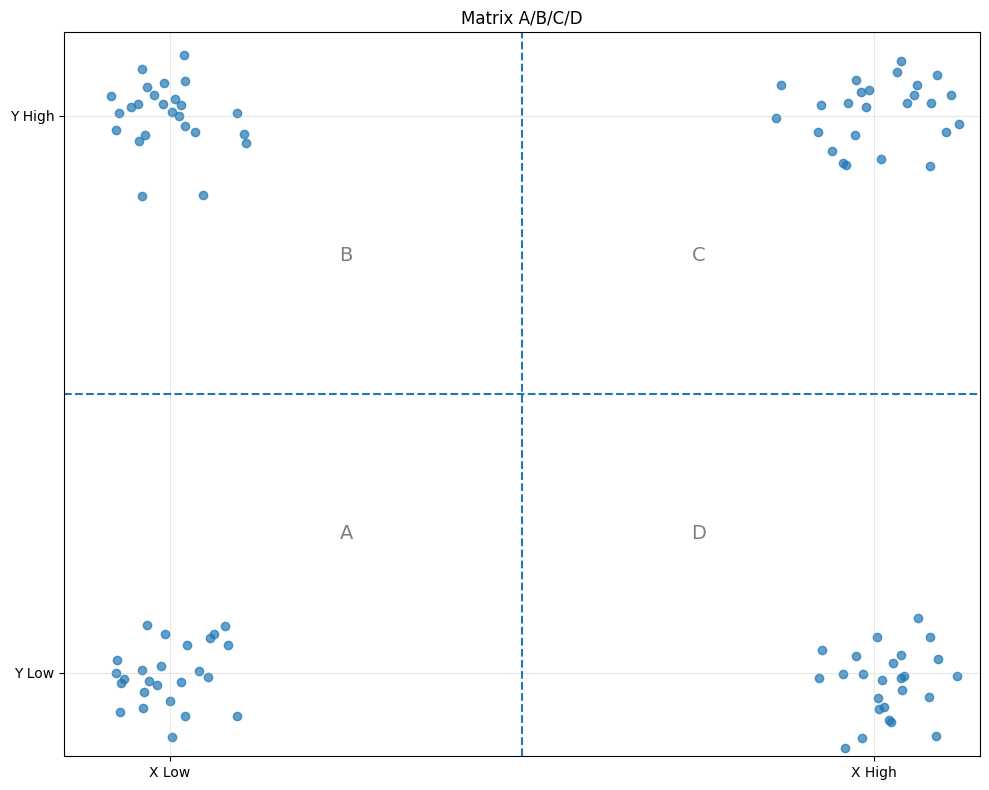

In [ ]:
# ============================================
# Qualitative 2×2 Matrix (A/B/C/D) from Excel
# - Upload .xlsx file
# - Choose categorical X and Y columns (e.g., "Educated", "Rich")
# - Define which phrases map to High vs Low for each axis
# - Draws ONE vertical & ONE horizontal split → 4 quadrants
# - No bubble size logic (uniform point size)
# ============================================

!pip -q install pandas numpy matplotlib openpyxl ipywidgets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import (
    Dropdown, Textarea, RadioButtons, Checkbox,
    Button, HBox, VBox, Output, Label, Text
)
from IPython.display import display, clear_output
from google.colab import files

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.grid"] = True

state = {"sheets": None, "df": None}

# ---------- Robust sheet loading ----------
def _first_nonempty_header_row(df_raw: pd.DataFrame, min_nonempty=2):
    for i in range(len(df_raw)):
        row = df_raw.iloc[i]
        nonempty = row.map(lambda x: isinstance(x, str) and x.strip() != "" or pd.notna(x)).sum()
        if nonempty >= min_nonempty:
            return i
    return 0

def _load_sheet_robust(xls, sheet_name):
    raw = xls.parse(sheet_name, header=None)
    raw = raw.dropna(how="all")
    if raw.empty: return pd.DataFrame()
    hdr_idx = _first_nonempty_header_row(raw, min_nonempty=2)
    header = raw.iloc[hdr_idx].fillna("").astype(str).str.strip()
    df = raw.iloc[hdr_idx+1:].copy()
    df.columns = [c if c != "" else f"Col{j+1}" for j, c in enumerate(header)]
    df.columns = [str(c).strip() for c in df.columns]
    df = df.dropna(axis=1, how="all").dropna(how="all")
    return df

# ---------- Upload ----------
upload_btn = Button(description="Upload Excel", button_style="primary")
status_out, preview_out = Output(), Output()

def on_upload(_):
    with status_out:
        clear_output()
        print("📤 Choose an .xlsx file...")
    uploaded = files.upload()
    if not uploaded:
        return
    fname = list(uploaded.keys())[0]
    try:
        xls = pd.ExcelFile(f"/content/{fname}", engine="openpyxl")
        sheets = {name: _load_sheet_robust(xls, name) for name in xls.sheet_names}
        state["sheets"] = sheets
        with status_out:
            print(f"✅ Uploaded: {fname}")
            print("Sheets:", list(sheets.keys()))
        refresh_selectors()
        with preview_out:
            clear_output()
            for n, df in sheets.items():
                print(f"\nPreview of '{n}' (first 5 rows):")
                display(df.head())
    except Exception as e:
        with status_out:
            print(f"❌ Failed to read Excel: {e}")

upload_btn.on_click(on_upload)
display(upload_btn, status_out, preview_out)

# ---------- UI ----------
sheet_dd   = Dropdown(description="Sheet:")
xcol_dd    = Dropdown(description="X Column:")  # e.g., Educated
ycol_dd    = Dropdown(description="Y Column:")  # e.g., Rich
label_dd   = Dropdown(description="Labels:", options=[("None", None)], value=None)

# Category mapping inputs (comma-separated lists)
x_high_txt = Textarea(
    value="very educated, educated, yes, high",
    description="X High terms:",
    layout={'width': '500px', 'height': '60px'}
)
x_low_txt = Textarea(
    value="not educated, no, low, medium educated",
    description="X Low terms:",
    layout={'width': '500px', 'height': '60px'}
)
y_high_txt = Textarea(
    value="very rich, rich, yes, high",
    description="Y High terms:",
    layout={'width': '500px', 'height': '60px'}
)
y_low_txt = Textarea(
    value="not rich, poor, no, low, medium rich",
    description="Y Low terms:",
    layout={'width': '500px', 'height': '60px'}
)

# What to do with values not matching any term?
x_other_rb = RadioButtons(
    options=["Treat as Low", "Treat as High", "Exclude row"],
    value="Treat as Low",
    description="X other:"
)
y_other_rb = RadioButtons(
    options=["Treat as Low", "Treat as High", "Exclude row"],
    value="Treat as Low",
    description="Y other:"
)

show_labels = Checkbox(value=False, description="Show point labels")

go_btn = Button(description="Generate Matrix", button_style="success")
ui_out, plot_out, table_out = Output(), Output(), Output()

def refresh_selectors():
    if not state.get("sheets"): return
    valid = {k:v for k,v in state["sheets"].items() if not v.empty}
    state["sheets"] = valid
    sheet_dd.options = list(valid.keys())
    if sheet_dd.options:
        sheet_dd.value = sheet_dd.options[0]
        _fill_columns()

def _fill_columns(*_):
    df = state["sheets"][sheet_dd.value]
    state["df"] = df
    cols = df.columns.tolist()
    xcol_dd.options = cols
    ycol_dd.options = cols
    label_dd.options = [("None", None)] + [(c, c) for c in cols]

sheet_dd.observe(_fill_columns, names="value")

display(VBox([
    Label("Pick your sheet & columns:"),
    HBox([sheet_dd]),
    HBox([xcol_dd, ycol_dd]),
    HBox([label_dd]),
    Label("Define which phrases count as HIGH vs LOW (comma-separated). Matching is case-insensitive and allows substring matches."),
    x_high_txt, x_low_txt, y_high_txt, y_low_txt,
    HBox([x_other_rb, y_other_rb]),
    HBox([show_labels]),
    go_btn
]), ui_out, plot_out, table_out)

# ---------- Mapping helpers ----------
def _parse_terms(s):
    return [t.strip().lower() for t in (s or "").split(",") if t.strip()]

def _bin_from_terms(val, high_terms, low_terms, policy):
    """
    Return 1 for High, 0 for Low, or None to exclude row.
    Matching is case-insensitive; if exact not found, does substring match.
    """
    if val is None:
        return None if "Exclude" in policy else (1 if "High" in policy else 0)

    v = str(val).strip().lower()

    # exact match
    if v in high_terms: return 1
    if v in low_terms:  return 0

    # substring match (so 'very educated' matches 'educated' if listed)
    if any(t and t in v for t in high_terms): return 1
    if any(t and t in v for t in low_terms):  return 0

    # fallback policy
    if "Exclude" in policy: return None
    return 1 if "High" in policy else 0

# ---------- Generate ----------
def on_generate(_):
    with ui_out: clear_output()
    with plot_out: clear_output()
    with table_out: clear_output()

    if state.get("df") is None:
        with ui_out: print("⚠️ Upload Excel first."); return

    df = state["df"].copy()
    xcol, ycol = xcol_dd.value, ycol_dd.value
    labcol = label_dd.value
    if not xcol or not ycol:
        with ui_out: print("⚠️ Please choose X and Y columns."); return

    # Build term sets
    x_high = _parse_terms(x_high_txt.value)
    x_low  = _parse_terms(x_low_txt.value)
    y_high = _parse_terms(y_high_txt.value)
    y_low  = _parse_terms(y_low_txt.value)

    # Map to binaries
    xb = df[xcol].map(lambda v: _bin_from_terms(v, x_high, x_low, x_other_rb.value))
    yb = df[ycol].map(lambda v: _bin_from_terms(v, y_high, y_low, y_other_rb.value))
    mask = xb.notna() & yb.notna()
    dropped = (~mask).sum()
    df = df.loc[mask].copy()
    df["_Xbin"] = xb[mask].astype(int)
    df["_Ybin"] = yb[mask].astype(int)

    if df.empty:
        with ui_out:
            print("⚠️ No rows remain after mapping categories. Adjust your High/Low terms or 'other' handling.")
        return

    # Labels
    labels = df[labcol].astype(str) if labcol else df.index.astype(str)

    # Jitter (so overlapping points spread a little)
    rng = np.random.default_rng(0)
    jitter = 0.06
    xj = df["_Xbin"].to_numpy() + rng.normal(0, jitter, size=len(df))
    yj = df["_Ybin"].to_numpy() + rng.normal(0, jitter, size=len(df))

    # Plot (one vertical & one horizontal line)
    fig, ax = plt.subplots()
    ax.scatter(xj, yj, alpha=0.7)  # uniform marker size, no bubble logic
    ax.axvline(x=0.5, linestyle="--")
    ax.axhline(y=0.5, linestyle="--")

    if show_labels.value:
        for (x, y, t) in zip(xj, yj, labels):
            ax.text(x, y, f" {t}", fontsize=9, va="center")

    ax.set_xticks([0, 1]); ax.set_xticklabels(["X Low", "X High"])
    ax.set_yticks([0, 1]); ax.set_yticklabels(["Y Low", "Y High"])
    ax.set_xlim(-0.15, 1.15); ax.set_ylim(-0.15, 1.15)
    ax.set_title("Matrix A/B/C/D")
    ax.grid(True, alpha=0.3)

    # Quadrant letters
    centers = [
        (0.25, 0.25, "A"),  # bottom-left
        (0.25, 0.75, "B"),  # top-left
        (0.75, 0.75, "C"),  # top-right
        (0.75, 0.25, "D"),  # bottom-right
    ]
    for xc, yc, name in centers:
        ax.text(xc, yc, name, ha="center", va="center", fontsize=14, alpha=0.5)

    plt.tight_layout()
    with plot_out:
        display(fig)

    # Summary
    df["Quadrant"] = df.apply(
        lambda r: "A" if (r["_Xbin"]==0 and r["_Ybin"]==0)
        else ("B" if (r["_Xbin"]==0 and r["_Ybin"]==1)
        else ("C" if (r["_Xbin"]==1 and r["_Ybin"]==1) else "D")),
        axis=1
    )
    summary = df["Quadrant"].value_counts().rename_axis("Quadrant").reset_index(name="Count")

    with table_out:
        if dropped:
            print(f"ℹ️ Dropped {dropped} row(s) that didn't match any High/Low terms (per your 'other' settings).")
        print("Quadrant counts:")
        display(summary)

go_btn.on_click(on_generate)

print("✅ Ready. Upload your Excel, select the categorical columns, set High/Low terms, and Generate.")